# Dump Delight files

In [24]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import sys
sys.path.append('../')
from delight.io import *
from delight.utils import *
from delight.photoz_gp import PhotozGP

In [25]:
plt.rcParams["figure.figsize"] = (6,4)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [26]:
! ls 

DumpDelightFiles.ipynb	compareDelightSimDESCRAILFluxRedshift.ipynb  tmpsim
README.md		tmp


In [28]:
# First read a bunch of useful stuff from the parameter file.
params = parseParamFile('tmp/parametersTest.cfg', verbose=False)

# bands
bandCoefAmplitudes, bandCoefPositions, bandCoefWidths, norms = readBandCoefficients(params)
bandNames = params['bandNames']
print('bandNames:',bandNames)
numBands, numCoefs = bandCoefAmplitudes.shape

# fluxes and redshift
fluxredshifts = np.loadtxt(params['target_catFile'])
print('target_catFile:',params['target_catFile'])
fluxredshifts_train = np.loadtxt(params['training_catFile'])
print('training_catFile:',params['training_catFile'])
bandIndices, bandNames, bandColumns, bandVarColumns, redshiftColumn, refBandColumn = readColumnPositions(params, prefix='target_')

# redshift
redshiftDistGrid, redshiftGrid, redshiftGridGP = createGrids(params)
dir_seds = params['templates_directory']
print('templates_directory:',params['templates_directory'])

# filters
dir_filters = params['bands_directory']
print('bands_directory:',params['bands_directory'])
lambdaRef = params['lambdaRef']

#sed
sed_names = params['templates_names']
nt = len(sed_names)
f_mod = np.zeros((redshiftGrid.size, nt, len(params['bandNames'])))
for t, sed_name in enumerate(sed_names):
    f_mod[:, t, :] = np.loadtxt(dir_seds + '/' + sed_name + '_fluxredshiftmod.txt')

bandNames: ['lsst_u', 'lsst_g', 'lsst_r', 'lsst_i', 'lsst_z', 'lsst_y']
target_catFile: ./tmp/delight_data/galaxies-fluxredshifts2.txt
training_catFile: ./tmp/delight_data/galaxies-fluxredshifts.txt
templates_directory: /home/ubuntu/.local/lib/python3.8/site-packages/delight/../data/CWW_SEDs
bands_directory: /home/ubuntu/.local/lib/python3.8/site-packages/delight/../data/FILTERS


# catalog

In [29]:
bandIndices, bandNames, bandColumns, bandVarColumns, redshiftColumn,refBandColumn = readColumnPositions(params, prefix="training_")

In [30]:
redshiftColumn

12

In [31]:
bandIndices

array([0, 1, 2, 3, 4, 5])

In [32]:
bandNames

array(['lsst_u', 'lsst_g', 'lsst_r', 'lsst_i', 'lsst_z', 'lsst_y'],
      dtype='<U6')

In [33]:
bandColumns

array([ 0,  2,  4,  6,  8, 10])

In [34]:
bandVarColumns

array([ 1,  3,  5,  7,  9, 11])

In [35]:
refBandColumn

6

# Model

In [36]:
f_mod.shape

(3001, 8, 6)

Text(0.5, 0.98, 'Magnitude distribution for different templates')

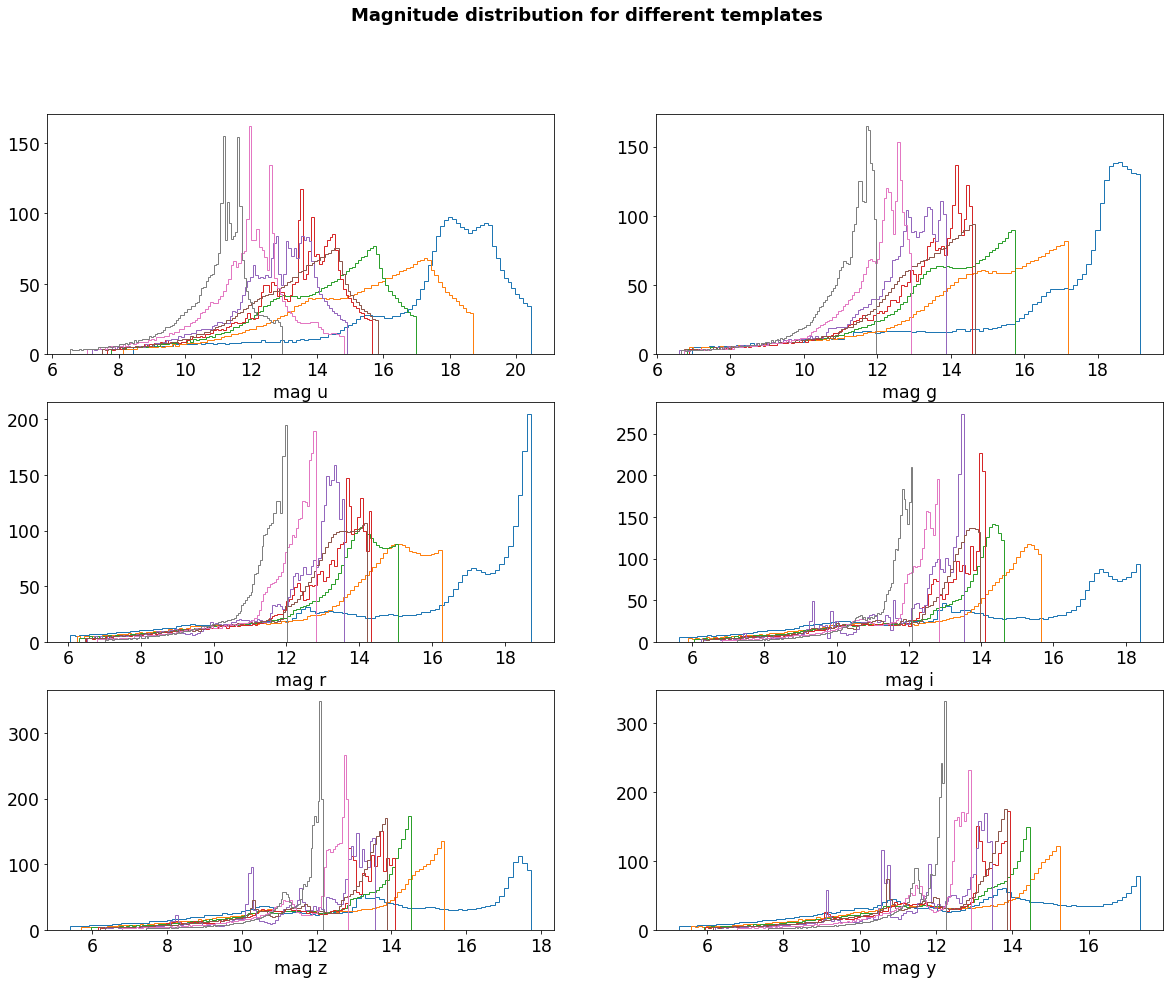

In [37]:
fig=plt.figure(figsize=(20,15))

ax=fig.add_subplot(321)
idb=0
for ids in np.arange(8):
    ax.hist(-2.5*np.log10(f_mod[:,ids,idb]),bins=100,histtype='step');
ax.set_xlabel("mag u")

ax=fig.add_subplot(322)
idb=1
for ids in np.arange(8):
    ax.hist(-2.5*np.log10(f_mod[:,ids,idb]),bins=100,histtype='step');
ax.set_xlabel("mag g")

ax=fig.add_subplot(323)
idb=2
for ids in np.arange(8):
    ax.hist(-2.5*np.log10(f_mod[:,ids,idb]),bins=100,histtype='step');
ax.set_xlabel("mag r")

ax=fig.add_subplot(324)
idb=3
for ids in np.arange(8):
    ax.hist(-2.5*np.log10(f_mod[:,ids,idb]),bins=100,histtype='step');
ax.set_xlabel("mag i")

ax=fig.add_subplot(325)
idb=4
for ids in np.arange(8):
    ax.hist(-2.5*np.log10(f_mod[:,ids,idb]),bins=100,histtype='step');
ax.set_xlabel("mag z")

ax=fig.add_subplot(326)
idb=5
for ids in np.arange(8):
    ax.hist(-2.5*np.log10(f_mod[:,ids,idb]),bins=100,histtype='step');
ax.set_xlabel("mag y")

plt.suptitle("Magnitude distribution for different templates",fontsize=18,fontweight='bold')

# training

In [38]:
training_file=params['training_catFile']

In [39]:
training_data=np.loadtxt(training_file)

In [40]:
train_redshift=training_data[:,redshiftColumn]

In [41]:
flux_lsst_u=training_data[:,0]
flux_lsst_g=training_data[:,2]
flux_lsst_r=training_data[:,4]
flux_lsst_i=training_data[:,6]
flux_lsst_z=training_data[:,8]
flux_lsst_y=training_data[:,10]

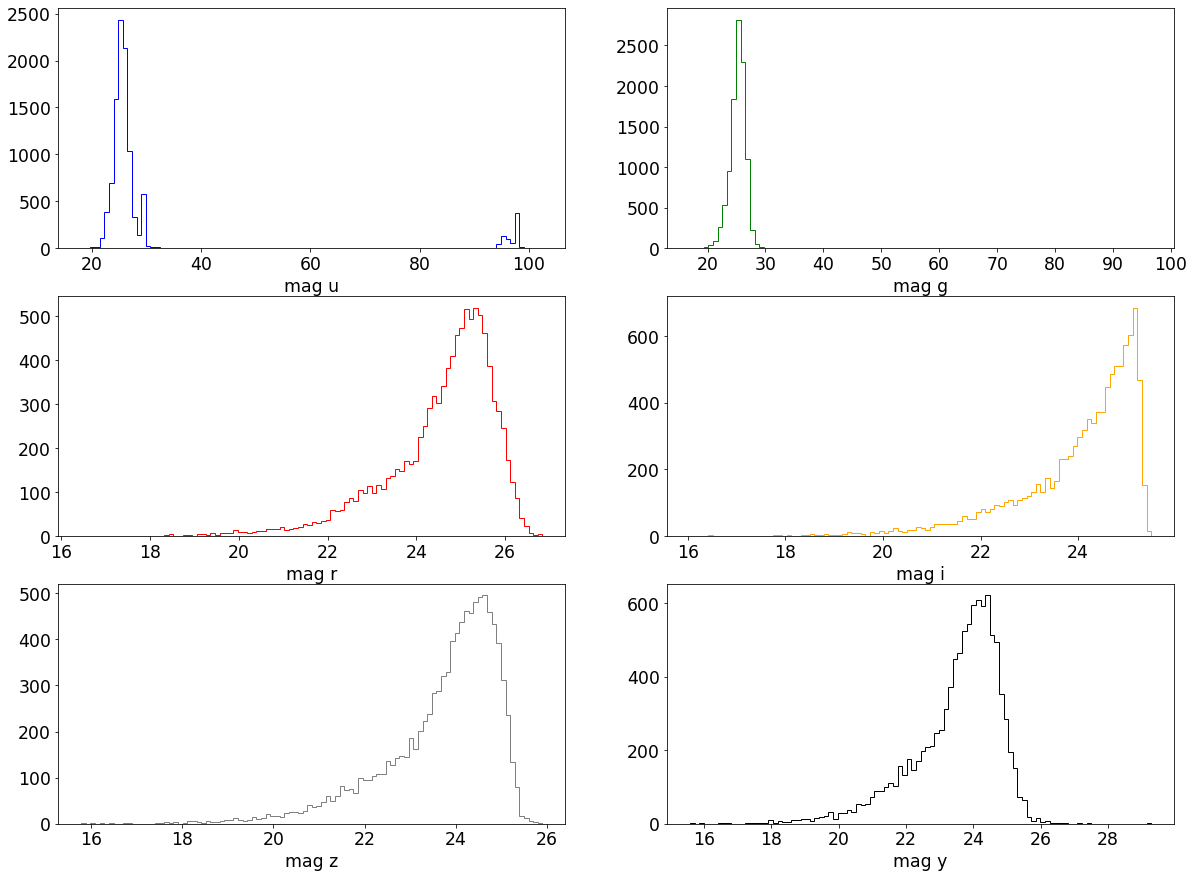

In [42]:
fig=plt.figure(figsize=(20,15))

ax1=fig.add_subplot(321)

ax1.set_xlabel("mag u")
ax1.hist(-2.5*np.log10(flux_lsst_u),bins=100,color="b",histtype='step');

ax2=fig.add_subplot(322)

ax2.set_xlabel("mag g")
ax2.hist(-2.5*np.log10(flux_lsst_g),bins=100,color="g",histtype='step');


ax3=fig.add_subplot(323)

ax3.set_xlabel("mag r")
ax3.hist(-2.5*np.log10(flux_lsst_r),bins=100,color="r",histtype='step');

ax4=fig.add_subplot(324)

ax4.set_xlabel("mag i")
ax4.hist(-2.5*np.log10(flux_lsst_i),bins=100,color="orange",histtype='step');


ax5=fig.add_subplot(325)

ax5.set_xlabel("mag z")
ax5.hist(-2.5*np.log10(flux_lsst_z),bins=100,color="grey",histtype='step');

ax6=fig.add_subplot(326)

ax6.set_xlabel("mag y")
ax6.hist(-2.5*np.log10(flux_lsst_y),bins=100,color="k",histtype='step');



Text(0, 0.5, 'mag_lsst_y')

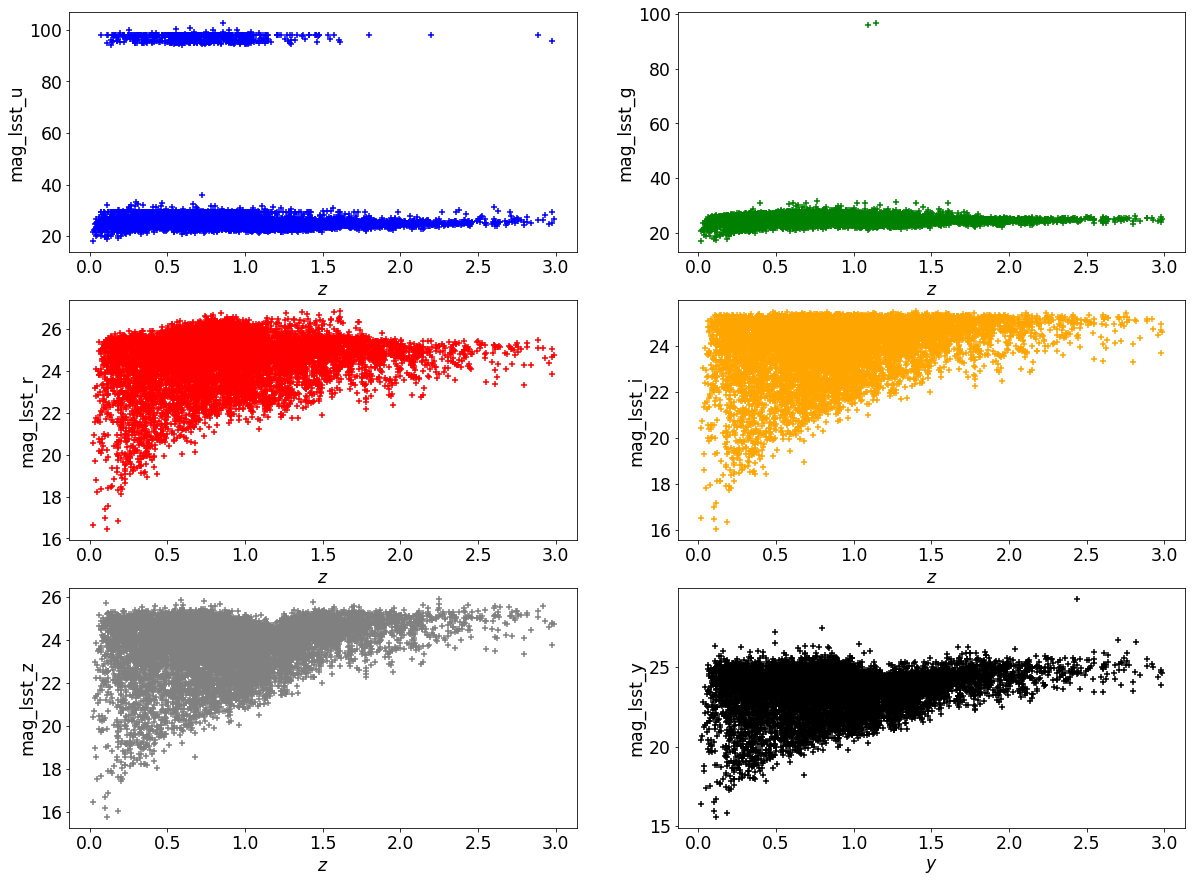

In [43]:
fig=plt.figure(figsize=(20,15))
ax1=fig.add_subplot(321)
ax1.scatter(train_redshift,-2.5*np.log10(flux_lsst_u),marker="+",color='b')
ax1.set_xlabel("$z$")
ax1.set_ylabel("mag_lsst_u")

ax2=fig.add_subplot(322)
ax2.scatter(train_redshift,-2.5*np.log10(flux_lsst_g),marker="+",color='g')
ax2.set_xlabel("$z$")
ax2.set_ylabel("mag_lsst_g")

ax1=fig.add_subplot(323)
ax1.scatter(train_redshift,-2.5*np.log10(flux_lsst_r),marker="+",color='r')
ax1.set_xlabel("$z$")
ax1.set_ylabel("mag_lsst_r")

ax2=fig.add_subplot(324)
ax2.scatter(train_redshift,-2.5*np.log10(flux_lsst_i),marker="+",color='orange')
ax2.set_xlabel("$z$")
ax2.set_ylabel("mag_lsst_i")


ax1=fig.add_subplot(325)
ax1.scatter(train_redshift,-2.5*np.log10(flux_lsst_z),marker="+",color='grey')
ax1.set_xlabel("$z$")
ax1.set_ylabel("mag_lsst_z")

ax2=fig.add_subplot(326)
ax2.scatter(train_redshift,-2.5*np.log10(flux_lsst_y),marker="+",color='k')
ax2.set_xlabel("$y$")
ax2.set_ylabel("mag_lsst_y")


Text(0.5, 0, 'z')

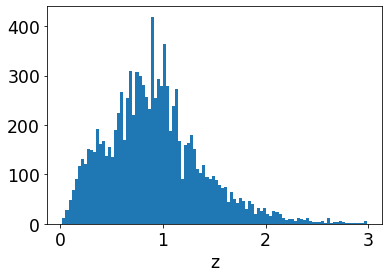

In [44]:
fig=plt.figure(figsize=(6,4))

ax=fig.add_subplot(111)
ax.hist(train_redshift,bins=100);
ax.set_xlabel("z")